### Spark ML__Moive Recommendation

In [2]:
"""

# download data to fs and unzip
%sh
curl -o /tmp/ml-20m.zip http://files.grouplens.org/datasets/movielens/ml-20m.zip
unzip /tmp/ml-20m.zip -d /tmp

# transfer file to dbfs
%fs cp -r file:/tmp/ml-20m dbfs:/FileStore/ml-20m
    
# clean up space
dbutils.fs.rm("file:/tmp/ml-20m", True)
dbutils.fs.rm("file:/tmp/ml-20m.zip", True)

"""

Out[ 1 ]: '\n\n# download data to fs and unzip\n%sh\ncurl -o /tmp/ml-20m.zip http://files.grouplens.org/datasets/movielens/ml-20m.zip\nunzip /tmp/ml-20m.zip -d /tmp\n\n# transfer file to dbfs\n%fs cp -r file:/tmp/ml-20m dbfs:/FileStore/ml-20m\n \n# clean up space\ndbutils.fs.rm("file:/tmp/ml-20m", True)\ndbutils.fs.rm("file:/tmp/ml-20m.zip", True)\n\n'

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import max, min
from pyspark.sql.functions import UserDefinedFunction, explode
from pyspark.sql.types import StringType, ArrayType

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math, time

%matplotlib inline

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

### Data ETL and Data Exploration (Spark SQL and OLAP )

In [5]:
spark = SparkSession.builder.appName("moive_recommendation").getOrCreate()

In [6]:
csv_path = "/FileStore/ml-20m"
movies = spark.read.load("{}/movies.csv".format(csv_path), format='csv', header = True)
ratings = spark.read.load("{}/ratings.csv".format(csv_path), format='csv', header = True)

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
ratings.show(5)

+------+-------+------+----------+
userId|movieId|rating| timestamp|
+------+-------+------+----------+
 1| 2| 3.5|1112486027|
 1| 29| 3.5|1112484676|
 1| 32| 3.5|1112484819|
 1| 47| 3.5|1112484727|
 1| 50| 3.5|1112484580|
+------+-------+------+----------+
only showing top 5 rows

In [9]:
# verify data count
movies.count(), ratings.count()

Out[ 7 ]: (27278, 20000263)

In [10]:
# determine minimum number of ratings per user or movie
min_user = ratings.groupBy("userId").count().toPandas()['count'].min()
min_movie = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(min_user))
print('Minimum number of ratings per movie is {}'.format(min_movie))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [11]:
# movies that are rated by one user
one_rating_movie = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
dist_movie = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(one_rating_movie, dist_movie))

3972 out of 26744 movies are rated by only one user

In [12]:
# number of users
ratings.select('userId').distinct().count()

Out[ 10 ]: 138493

In [13]:
# number of movies
movies.select('movieId').distinct().count()

Out[ 11 ]: 27278

In [14]:
# number of movies rated by users
tmp = ratings.select('movieId').distinct().count()
print ('{} movies are rated by users'.format(tmp))

26744 movies are rated by users

In [15]:
# list movies not rated before
movies.registerTempTable('movies_table')
ratings.registerTempTable('ratings_table')

print ('Movies are not rated:')
spark.sql('select mv.movieId, title \
          from movies_table mv \
          left join ratings_table rt \
          on mv.movieID = rt.movieID \
          where rating is null') \
      .show(100, False)

Movies are not rated:
+-------+-----------------------------------------------------------------------------+
movieId|title |
+-------+-----------------------------------------------------------------------------+
119625 |Ex-Lady (1933) |
121849 |Long Day's Journey Into Night (1987) |
32773 |Parenti serpenti (1992) |
118786 |Comin' at Ya! (1981) |
119858 |Casablanca Express (1989) |
109319 |Gamera the Brave (2006) |
115027 |Appointment in Tokyo (1945) |
115690 |Very Social Secretary, A (2005) |
127579 |Black Venus (2010) |
96193 |Captain Video: Master of the Stratosphere (1951) |
120614 |How to Eat Your Watermelon in White Company (and Enjoy It) (2005) |
120843 |North and South, Book II (1986) |
109767 |Toomorrow (1970) |
110761 |Bright Lights (Adventures in Africa) (1930) |
117746 |The Fearmakers (1958) |
121845 |Onibi: The Fire Within (1997) |
122220 |The Man Without a Map (1968) |
128876 |Saban, Son of Saban (1977) |
31797 |White Banners (1938) |
127214 |Stockholm, Pennsylvania (2015) |
89806 |Proud and the Beautiful, The (Orgueilleux, Les) (Proud Ones, The) (1953) |
116205 |The Clinic (2010) |
116746 |Deadline (2011) |
120518 |The Hellions (1961) |
86949 |One Hundred Mornings (2009) |
118520 |Between Miracles (1972) |
119758 |Woman of Antwerp (1948) |
101224 |3some (Castillos de cartón) (2009) |
110136 |Amazonia (2013) |
117324 |Nothing to Lose (2008) |
117690 |Enchantment (1948) |
118089 |Sport, Sport, Sport (1970) |
33573 |Wu Tang Master (Tian shi zhuang xie) (1983) |
96598 |Wild Wild West Revisited, The (1979) |
116885 |The Man Who Played God (1932) |
127170 |Here be Dragons (2013) |
121729 |The Challenge (1970) |
121841 |Mantle (2005) |
85476 |Wild Is the Wind (1957) |
101407 |Laffghanistan: Comedy Down Range (2009) |
119316 |Professor Beware (1938) |
89341 |Night Ambush (Ill Met by Moonlight) (1957) |
111318 |City Under Siege (Chun sing gai bei) (2010) |
112353 |Fine Pair, A (Ruba al prossimo tuo) (1968) |
112751 |Ju-on: The Beginning of the End (Ju-on: Owari no hajimari) (2014) |
116253 |IMAX: Coral Reef Adventure (2003) |
117981 |Pool of London (1951) |
122371 |Let the Good Times Roll (1973) |
127667 |Riviera (1954) |
96086 |Householder, The (Gharbar) (1963) |
116698 |Dead Men Tell (1941) |
128277 |Break-in (1939) |
128872 |Love is God (2003) |
92268 |Queen of the Amazons (1947) |
111997 |Hot Rods to Hell (1967) |
129443 |Thank You a Lot (2014) |
112023 |Annabel Takes a Tour (Annabel Takes a Trip) (1938) |
115423 |My Father and the Man in Black (2012) |
115965 |Dead Man's Bluff (2005) |
109231 |Beyond the Law (Lain ulkopuolella) (1987) |
118790 |Holy Flying Circus (2011) |
90116 |One Potato, Two Potato (1964) |
106859 |Amen (2013) |
125603 |The Living Magoroku (1943) |
96275 |In Custody (1994) |
121777 |Rebirth (2011) |
125605 |Jubilation Street (1943) |
77451 |Operator 13 (1934) |
94435 |Over-Eater, The (L'outremangeur) (2003) |
102417 |Sicily! (Sicilia!) (1999) |
121233 |Take a Girl Like You (1970) |
126116 |Dolls and Angels (2008) |
121057 |The Well-Digger's Daughter (1940) |
117901 |Showrunners: The Art of Running a TV Show (2014) |
127606 |The Questor Tapes (1974) |
104750 |Killjoy 3 (2010) |
118017 |The Living Idol (1957) |
118920 |Butterfly Girl (2014) |
121249 |The Magical Legend of the Leprechauns (1999) |
127498 |Private Confessions (1996) |
88833 |There Goes My Heart (1938) |
101216 |Shadow Boxers (1999) |
110539 |Maternal Halfbrothers (Braca po materi) (1988) |
116341 |Dana Carvey: Squatting Monkeys Tell No Lies (2008) |
121011 |Imagine I'm Beautiful (2014) |
121618 |The Great Gatsby (1926) |
102821 |India: Matri Bhumi (1959) |
119595 |Deceit (1992) |
121875 |Submarine (1928) |
127160 |In Football We Trust (2015) |
101237 |9500 Liberty (2009) |
106521 |Beyond the Time Barrier (1960) |
116672 |David Cross: The Pride Is Back (1999) |
121763 |Without Lying Down: Frances Marion and the Power of Women in Hollywood (2000)|
103641 |D-Day (2013) |
122393 |Sam Peckinpah's West: Legacy of a Hollywood Renegade (200

In [16]:
# list movie genres
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

+------------------+
 genres|
+------------------+
 Crime|
 Romance|
 Thriller|
 Adventure|
 Drama|
 War|
 Documentary|
 Fantasy|
 Mystery|
 Musical|
 Animation|
 Film-Noir|
(no genres listed)|
 IMAX|
 Horror|
 Western|
 Comedy|
 Children|
 Action|
 Sci-Fi|
+------------------+

In [17]:
# movie for each category
movies.select('movieId', explode(splitter("genres")).alias("genres")).groupby('genres').count().sort('count').show()

+------------------+-----+
 genres|count|
+------------------+-----+
 IMAX| 196|
(no genres listed)| 246|
 Film-Noir| 330|
 Western| 676|
 Animation| 1027|
 Musical| 1036|
 Children| 1139|
 War| 1194|
 Fantasy| 1412|
 Mystery| 1514|
 Sci-Fi| 1743|
 Adventure| 2329|
 Documentary| 2471|
 Horror| 2611|
 Crime| 2939|
 Action| 3520|
 Romance| 4127|
 Thriller| 4178|
 Comedy| 8374|
 Drama|13344|
+------------------+-----+

### Spark ALS based approach for training model

In [20]:
# read in data and cache the partitions
file_path = '/FileStore/ml-20m/ratings.csv'

def load_process_data(file):
  movie_rating = sc.textFile(file)

  header = movie_rating.take(1)[0]
  rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(',')).map(lambda tokens:(int(tokens[0]), int(tokens[1]), float(tokens[2]))).cache()

  # create dataframe from rdd
  df_rating_data = spark.createDataFrame(rating_data)
  rating_data = df_rating_data \
                      .withColumnRenamed('_1', 'userId') \
                      .withColumnRenamed('_2', 'movieId') \
                      .withColumnRenamed('_3', 'rating')

  # split the data into training/validation/testing sets using a 6/2/2 ratio
  train_, validation_, test_ = rating_data.randomSplit([6.0,2.0,2.0], seed = 99)
  return train_, validation_, test_, rating_data


train, validation, test, ratings_training = load_process_data(file_path)

ratings_training.cache()
train.cache()
validation.cache()
test.cache()

Out[ 16 ]: DataFrame[userId: bigint, movieId: bigint, rating: double]

### ALS Model Selection and Evaluation

The cross validation takes a long time on a 20M dataset, so use train test split instead.

In [23]:
# choose whether to use cross validation for fine tuning the parameters or use train_test_split for saving time, set corss_validate=True to use CrossValidator
def train_als(training_data, testing_data, cross_validate=False):
  als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
  evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
  paramGrid = ParamGridBuilder() \
              .addGrid(als.maxIter, [5]) \
              .addGrid(als.rank, [_ for _ in range(10, 20, 3)]) \
              .addGrid(als.regParam, [0.05, 0.1, 0.15, 0.2]) \
              .build()
  if cross_validate:
    print ('Use k-fold cross validation')
    crossval = CrossValidator(estimator=als,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator, 
                             numFolds=3)
    model = crossval.fit(training_data)
  else:
    print ('Use train test split once')
    tvs = TrainValidationSplit(estimator=als,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             trainRatio=0.8)
    model = tvs.fit(training_data)

  prediction = model.transform(testing_data)
  return model, prediction

In [24]:
best_model, model_prediction = train_als(ratings_training, test, cross_validate=False)

Use train test split once
/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [25]:
best_reg_param = best_model.bestModel._java_obj.parent().getRegParam()
best_iter = best_model.bestModel._java_obj.parent().getMaxIter()
best_rank = best_model.bestModel.rank
print ("The optimal regularizaiton parameter is: {}\nThe optimal iternation is: {}\nThe optimal number of latent factors is: {}".format(best_reg_param, best_iter, best_rank))

The optimal regularizaiton parameter is: 0.05
The optimal iternation is: 5
The optimal number of latent factors is: 10

In [26]:
display(model_prediction)

userId,movieId,rating,prediction
36821,148,4.0,3.028714
83090,148,2.0,2.0163252
32882,148,3.0,2.6373851
5585,148,3.0,3.276081
96884,148,4.0,2.5169227
136453,148,2.0,2.7066813
21326,148,4.0,2.9113019
59570,148,3.0,2.6763778
3673,148,2.0,2.5202684
111523,148,2.0,3.2385163


In [27]:
# training error -- pass in trained best parameters
best_als = ALS(rank=best_rank, maxIter=best_iter, regParam=best_reg_param, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
predictions = best_als.fit(train).transform(validation)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print ('Validation RMSE is {:.4f}'.format(rmse))

Validation RMSE is 0.8089

### Model Testing and Learning Curve

In [29]:
# testing error
test_model = ALS(rank=best_rank, maxIter=best_iter, regParam=best_reg_param, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
predictions = test_model.fit(ratings_training).transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print ('The holdout test RMSE is {:.4f}'.format(rmse))

The holdout test RMSE is 0.7519

In [30]:
# calculate error under different iteration scenarios
iteration_array = [_ for _ in range(1, 8)]

def calc_errors(iterations, train_data, validation_data, reg=best_reg_param, rank=best_rank):
  print ('Now using: rank={}, reg={}'.format(rank, reg))
  errors = []
  for iteration in iterations:
    print ('Now testing {} iterations'.format(iteration))
    als = ALS(rank=rank, maxIter=iteration, regParam=reg, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
    model = als.fit(train_data)
    predictions = model.transform(validation_data)
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
    errors.append(evaluator.evaluate(predictions))
  return errors

errors_calculated = calc_errors(iteration_array, train, validation)

Now using: rank=10, reg=0.05
Now testing 1 iterations
Now testing 2 iterations
Now testing 3 iterations
Now testing 4 iterations
Now testing 5 iterations
Now testing 6 iterations
Now testing 7 iterations

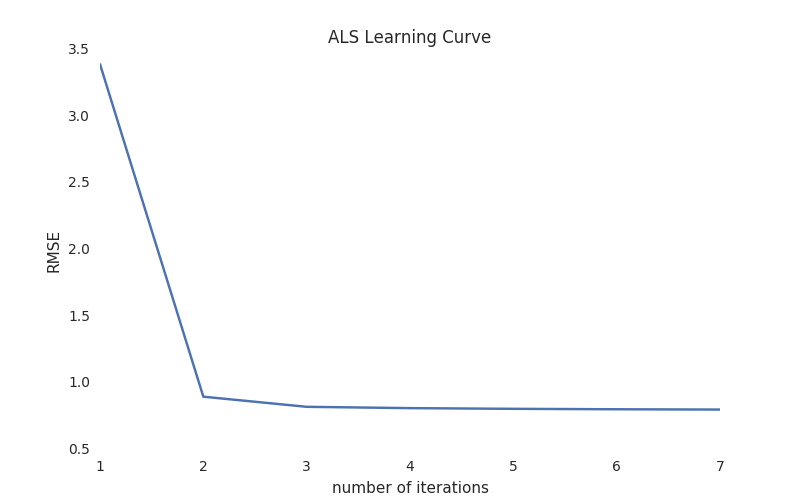

In [31]:
# plot the learning curve 
def plot_learning_curve(iter_arr, errors_calc):  
  plt.figure(figsize=(8,5))
  plt.plot(iter_arr, errors_calc)
  plt.xlabel('number of iterations')
  plt.ylabel('RMSE')
  plt.title('ALS Learning Curve')
  plt.grid(True)
  plt.show()
    
display(plot_learning_curve(iteration_array, errors_calculated))

After three iterations, RMSE for training data converges, which means we can stop where the RMSE starts to not decrease drastically to be more cost-effective on training.

### Apply your Model

##### Recommend to existing user

In [36]:
def top_n_recs(best_model, user_id, n):  
  # calculate top five movies for a user and top five items for an item
  user_recs = best_model.bestModel.recommendForAllUsers(n)
  item_recs = best_model.bestModel.recommendForAllItems(n)

  # given a user, recommend the top five movies
  row = user_recs.filter(user_recs['userId'] == user_id).select('recommendations').rdd.map(lambda x: x.recommendations).first()
  rdd = sc.parallelize(row)
  table = rdd.map(lambda x: Row(movieId=int(x[0]), rating=float(round(x[1], 4))))
  rec_movies = sqlContext.createDataFrame(table)

  rec_movies.registerTempTable('recMovies')
  movies.registerTempTable('movietable')
  print ('Top movies recommended for user {}:'.format(user_id))
  spark.sql('select m.movieId, title, genres, rating \
             from recMovies rm \
             left join movietable m \
             on rm.movieId = m.movieId') \
        .show(5, False)

##### Recommed to new user

In [38]:
# get movie ids that match user input
def extract_movie_ids(movies_df, user_input):
  matched_user_movieIDs = []
  for movie in user_input:
    matched_user_movieIDs.extend(movies_df.filter(movies_df.title.like('%{}%'.format(movie))) \
                                  .rdd.map(lambda r: r[0]) \
                                  .collect())
  return list(set(matched_user_movieIDs))


# add new users to training data
def aggregate_NewUsers(training_data, movie_ids, user_rating=5.0):
  new_user_id = training_data.select([max('userId')]).collect()[0]['max(userId)'] + 1
  new_user_rows = [(new_user_id, int(movie_id), user_rating) for movie_id in movie_ids]
  new_user_rows = spark.createDataFrame(new_user_rows) \
                      .withColumnRenamed('_1', 'userId') \
                      .withColumnRenamed('_2', 'movieId') \
                      .withColumnRenamed('_3', 'rating')
  new_ratings_df = training_data.union(new_user_rows)
  return new_ratings_df, new_user_id


# get new inference data
def create_new_user_inference(movies_df, movie_ids, added_user_id):
  new_user_input_list = movies_df.select('movieId').rdd \
                          .filter(lambda r: r[0] not in movie_ids) \
                          .map(lambda r: (added_user_id, int(r[0]))) \
                          .collect()

  user_df = spark.createDataFrame(new_user_input_list) \
                        .withColumnRenamed('_1', 'userId') \
                        .withColumnRenamed('_2', 'movieId')
  return user_df


# recommendations to new user top 10 movies
def recommend(training_data, movies_df, user_input, cur_bst_rank, cur_bst_reg):
  movieId_list = extract_movie_ids(movies_df, user_input)
  train_data, new_userIDs = aggregate_NewUsers(training_data, movieId_list, user_rating=5.0)
  inferences = create_new_user_inference(movies_df, movieId_list, new_userIDs)

  # train ALS using new user aggregated data
  als = ALS(rank=cur_bst_rank, maxIter=5, regParam=cur_bst_reg, userCol='userId', itemCol='movieId', ratingCol='rating', seed=99)
  model = als.fit(train_data)
  predictions = model.transform(inferences)
  
  top_n_ids = predictions.orderBy('prediction', ascending=False).filter(predictions.prediction != 'NaN').limit(10)
  
  top_n_ids.registerTempTable('topn_table')
  movies.registerTempTable('movies_table')
  
  results = spark.sql('with cte as ( \
                          select movieId, title, genres \
                          from movies_table \
                          where movieId in (select movieId from topn_table) \
                          ) \
                        select cte.movieId, title, genres, prediction \
                        from cte \
                        join topn_table top \
                        where cte.movieId = top.movieId \
                        order by prediction desc')
  return results

In [39]:
# show movies that match user's input if found and recommend to the top movies
def user_interation(training_data, movies_df, user_input, cur_bst_rank, cur_bst_reg):
  user_movies = []
  for mov in user_input:
    tmp = movies_df.filter(movies_df.title.like('%{}%'.format(mov))).collect()
    user_movies.extend(tmp)
    movies_found = spark.createDataFrame(user_movies)

  if movies_found.count() > 0:
    print ('Relevant movies found:')
    movies_found.show(5, False)
    print ('Suggested Movies:')
    recommendations = recommend(training_data, movies_df, user_input, cur_bst_rank, cur_bst_reg)
    recommendations.show(100, False)
  else:
    print ('Sorry, movies not found, please provide another movie.')
  return recommendations

In [40]:
if __name__ == '__main__':
  # recommend to existing user
  print ('----Recommendations for existing user----')
  top_n_recs(best_model, 471, 5)
  
  # recommend to new user
  print ('----Recommendations for new user----')
  user_input = ['Batman']
  res = user_interation(ratings_training, movies, user_input, best_rank, best_reg_param)

----Recommendations for existing user----
Top movies recommended for user 471:
+-------+----------------------------------------+----------------------+------+
movieId|title |genres |rating|
+-------+----------------------------------------+----------------------+------+
74159 |Ethan Mao (2004) |Drama|Thriller |5.9295|
85205 |Merry Widow, The (1925) |Drama|Romance |5.5055|
76022 |Restless Blood (Levoton veri) (1946) |Drama|Romance|Thriller|5.3127|
126219 |Marihuana (1936) |Documentary|Drama |5.3019|
77736 |Crazy Stone (Fengkuang de shitou) (2006)|Comedy|Crime |5.2779|
+-------+----------------------------------------+----------------------+------+

----Recommendations for new user----
Relevant movies found:
+-------+-----------------------------------+---------------------------------+
movieId|title |genres |
+-------+-----------------------------------+---------------------------------+
153 |Batman Forever (1995) |Action|Adventure|Comedy|Crime |
592 |Batman (1989) |Action|Crime|Thriller |
1377 |Batman Returns (1992) |Action|Crime |
1562 |Batman & Robin (1997) |Action|Adventure|Fantasy|Thriller|
3213 |Batman: Mask of the Phantasm (1993)|Animation|Children |
+-------+-----------------------------------+---------------------------------+
only showing top 5 rows

Suggested Movies:
+-------+----------------------------------------------------------------------------------------+-----------------------+----------+
movieId|title |genres |prediction|
+-------+----------------------------------------------------------------------------------------+-----------------------+----------+
104390 |When Nietzsche Wept (2007) |Drama |9.96309 |
126219 |Marihuana (1936) |Documentary|Drama |9.110984 |
97300 |Björk: Volumen (1999) |Animation|Musical |8.211327 |
84796 |8 Diagram Pole Fighter, The (a.k.a. Invincible Pole Fighter) (Wu Lang ba gua gun) (1984)|Action|Drama |7.874277 |
69464 |Angels of the Universe (Englar alheimsins) (2000) |Drama |7.703886 |
115685 |National Theatre Live: Frankenstein |Drama|Fantasy |7.6853876 |
27771 |Talking Picture, A (Um Filme Falado) (2003) |Comedy|Drama|War |7.6829796 |
34659 |She Creature (Mermaid Chronicles Part 1: She Creature) (2001) |Fantasy|Horror|Thriller|7.6752543 |
73529 |God’s Wedding (As Bodas de Deus) (1999) |Comedy |7.6558294 |
91046 |River Why, The (2010) |Drama |7.6231813 |
+-------+----------------------------------------------------------------------------------------+-----------------------+----------+

The higher the prediction is, the more interested the user will be in this movie.